# Домашняя работа №2
### Выполнила Елизавета Клыкова, БКЛ181
Включаем проверку на PEP-8, импортируем библиотеки...

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import json
import random
import numpy as np
from tqdm import tqdm
from collections import Counter

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

Задаем сид, чтобы результаты воспроизводились:

In [3]:
random.seed(117)
np.random.seed(117)
torch.manual_seed(117)
torch.cuda.manual_seed(117)
torch.backends.cudnn.deterministic = True

In [4]:
# самая сложная часть в домашке
torch.cuda.is_available()

True

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке *preprocessing.ipynb*.

In [5]:
# не забыть разархивировать файл
with open('data/processed_corpus.json', 'r', encoding='utf-8') as f:
    corpus = json.load(f)

In [6]:
len(corpus)

100000

In [7]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [8]:
sample_text = corpus[1]

In [9]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [10]:
def cbow_split(tokens, window, pad_token='PAD'):

    splits = []
    text_len = len(tokens)

    for n in range(text_len):

        # центральное слово
        central_word = tokens[n]

        # левый контекст
        if (n - window) > 0:
            left_context = tokens[(n-window):n]
        else:
            left_context = tokens[0:n]

        # добавляем PAD
        left_context = [pad_token] * (window - len(left_context)) \
            + left_context

        # правый контекст
        right_context = tokens[(n+1):(n+window+1)]
        right_context += [pad_token] * (window - len(right_context))

        splits.append((left_context, central_word, right_context))

    return splits

In [11]:
splits = cbow_split(sample_text, window=2)

In [12]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']

Левый контекст: ['денежный', 'средство']
Центральное слово: лицевой
Правый контекст: ['счёт', 'либо']

Левый контекст: ['средство', 'лицевой']
Центральное слово: счёт
Правый контекст: ['либо', 'зачесть']

Левый контекст: ['лицевой', 'счёт']
Центральное слово: либо
Правый контекст: ['зачесть', 'счёт']

Левый контекст: ['счёт', 'либо']
Центральное слово: зачесть
Правый контекст: ['счёт', 'погашение']

Левый контекст: ['либо', 'зачесть']
Центральное слово: счёт
Правый контекст: ['погашение', 'кредит']

Левый контекст: ['зачесть', 'счёт']
Центральное слово: погашение
Правый контекст: ['кредит', 'PAD']

Левый контекст: ['счёт', 'погашение']
Центральное слово: кредит
Правый контекст: [

In [13]:
splits

[(['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']),
 (['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']),
 (['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']),
 (['денежный', 'средство'], 'лицевой', ['счёт', 'либо']),
 (['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']),
 (['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']),
 (['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']),
 (['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']),
 (['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']),
 (['счёт', 'погашение'], 'кредит', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [14]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']),
 (['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']),
 (['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']),
 (['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']),
 (['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']),
 (['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']),
 (['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']),
 (['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']),
 (['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']),
 (['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [15]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом Skipgram

In [16]:
def skipgram_split(tokens, window):

    splits = []
    text_len = len(tokens)

    for i in range(text_len):

        central_word = tokens[i]

        if (i - window) >= 0:
            left_len = i - window
        else:
            left_len = 0

        left_context = tokens[left_len:i]

        if (i + window + 1) <= text_len:
            right_len = i + window + 1
        else:
            right_len = text_len

        right_context = tokens[i+1:right_len]

        context = left_context + right_context
        for cont in context:
            splits.append((cont, central_word))

    return splits

In [17]:
splits = skipgram_split(sample_text, window=2)

In [18]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный

Контекст: средство
Центральное слово: денежный

Контекст: лицевой
Центральное слово: денежный

Контекст: вернуть
Центральное слово: средство

Контекст: денежный
Центральное слово: средство

Контекст: лицевой
Центральное слово: средство

Контекст: счёт
Центральное слово: средство

Контекст: денежный
Центральное слово: лицевой

Контекст: средство
Центральное слово: лицевой

Контекст: счёт
Центральное слово: лицевой

Контекст: либо
Центральное слово: лицевой

Контекст: средство
Центральное слово: счёт

Контекст: лицевой
Центральное слово: счёт

Контекст: либо
Центральное слово: счёт

Контекст: зачесть
Центральное слово: счёт

Контекст: лицевой
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: зачесть
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: счёт
Центральное слово: зачесть

Контекст: либо
Цент

In [19]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('зачесть', 'погашение'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('счёт', 'кредит'),
 ('погашение', 'кредит')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [20]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('вернуть', 'лицевой'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('денежный', 'счёт'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('средство', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('погашение', 'либо'),
 ('лицевой', 'зачесть'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('кредит', 'зачесть'),
 ('счёт', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('либо', 'погашение'),
 ('зачесть', 'погашени

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [21]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [22]:
len(word2index)

13076

In [23]:
word2index['UNK']

1

In [24]:
[word2index[tok] if tok in word2index
 else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [25]:
from torch.utils.data import Dataset, DataLoader

In [26]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [27]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.45141113, 0.29933311, 0.2309617 , 0.8853034 ],
       [0.18644359, 0.93156671, 0.04540221, 0.75970544],
       [0.08780745, 0.14074832, 0.67584966, 0.96646157],
       [0.81806472, 0.89862461, 0.74417184, 0.72684547],
       [0.15089277, 0.73137032, 0.28175354, 0.58374409],
       [0.02739388, 0.03030734, 0.0218579 , 0.53899224],
       [0.07752654, 0.88674119, 0.970845  , 0.82929428],
       [0.78692053, 0.7303765 , 0.98339232, 0.50893489],
       [0.90838263, 0.59848902, 0.54664701, 0.75271567],
       [0.1017185 , 0.03260192, 0.75262785, 0.3642821 ]])

In [28]:
some_data_y

array([2, 2, 2, ..., 1, 1, 1])

In [29]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        return self.data_x[idx], self.data_y[idx]

In [30]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [31]:
some_dataset[5], some_dataset[467]

((array([0.02739388, 0.03030734, 0.0218579 , 0.53899224]), 1),
 (array([0.52510766, 0.64066169, 0.17227696, 0.5056511 ]), 1))

In [32]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [33]:
for x, y in some_loader:
    break

len(x), x

(16,
 tensor([[0.9497, 0.2477, 0.0820, 0.7899],
         [0.9094, 0.3224, 0.0522, 0.0927],
         [0.3932, 0.6151, 0.5788, 0.4957],
         [0.7733, 0.1349, 0.6188, 0.2731],
         [0.2485, 0.2245, 0.1562, 0.6645],
         [0.6553, 0.0022, 0.9235, 0.1509],
         [0.0666, 0.5620, 0.6837, 0.2552],
         [0.3837, 0.8529, 0.8717, 0.8885],
         [0.9539, 0.7751, 0.9535, 0.0514],
         [0.5247, 0.0318, 0.6941, 0.8291],
         [0.6438, 0.0649, 0.5960, 0.7720],
         [0.9391, 0.9469, 0.5426, 0.3230],
         [0.3994, 0.3894, 0.4701, 0.8339],
         [0.7579, 0.1217, 0.0271, 0.8452],
         [0.5402, 0.3355, 0.7931, 0.8172],
         [0.4728, 0.0779, 0.5686, 0.5386]], dtype=torch.float64))

In [34]:
for x, y in some_loader:
    pass

len(x)

15

In [35]:
# почему 13? (потому что 15)
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [36]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    @staticmethod
    def add_pow_features(x, n=2):

        return np.concatenate([x, x ** n])

    @staticmethod
    def add_log_features(x):

        return np.concatenate([x, np.log(x)])

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        x = self.data_x[idx]

        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)

        y = self.data_y[idx]

        return x, y

In [37]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [38]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [39]:
for x, y in toy_loader:
    break

In [40]:
x.shape

torch.Size([128, 32])

In [41]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.4514,   0.2993,   0.2310,  ...,  -7.2372,  -8.7930,  -0.7309],
        [  0.1864,   0.9316,   0.0454,  ...,  -0.4253, -18.5532,  -1.6489],
        [  0.0878,   0.1407,   0.6758,  ..., -11.7647,  -2.3507,  -0.2047],
        ...,
        [  0.2256,   0.2936,   0.3126,  ...,  -7.3531,  -6.9775,  -2.2453],
        [  0.8302,   0.5785,   0.2988,  ...,  -3.2834,  -7.2484,  -7.1828],
        [  0.6415,   0.5639,   0.6400,  ...,  -3.4374,  -2.6776,  -4.5696]],
       dtype=torch.float64)

In [42]:
y

tensor([2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 0, 1, 2, 0, 1, 1, 0, 2,
        2, 1, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 1, 2, 0, 0, 1, 1, 0, 0, 0,
        1, 2, 2, 2, 0, 2, 1, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 0, 2, 1, 2, 0, 2,
        1, 0, 2, 2, 1, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 0, 0,
        2, 0, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2,
        0, 0, 1, 1, 0, 2, 2, 1], dtype=torch.int32)

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [43]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [44]:
with torch.no_grad():

    prediction = model(x.float())
    # RuntimeError: expected scalar type Long but found Int
    loss = criterion(prediction, y.long())

loss.item()

1.1213287115097046

# Боевые датасеты

In [45]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value
                           in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []
        text_len = len(tokenized_text)

        for n in range(text_len):

            # центральное слово
            central_word = tokenized_text[n]

            # левый контекст
            if (n - self.window) > 0:
                left_context = tokenized_text[(n-self.window):n]
            else:
                left_context = tokenized_text[0:n]

            # добавляем PAD
            left_context = [self.pad_index] * \
                (self.window - len(left_context)) + left_context

            # правый контекст
            right_context = tokenized_text[(n+1):(n+self.window+1)]
            right_context += [self.pad_index] * \
                (self.window - len(right_context))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index
                else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [46]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        # дописанный инит класса
        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {
            value: key for key, value in self.word2index.items()
        }
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []
        text_len = len(tokenized_text)

        for i in range(text_len):

            central_word = tokenized_text[i]

            if (i - self.window) >= 0:
                left_len = i - self.window
            else:
                left_len = 0

            left_context = tokenized_text[left_len:i]

            if (i + self.window + 1) <= text_len:
                right_len = i + self.window + 1
            else:
                right_len = text_len

            right_context = tokenized_text[i+1:right_len]

            context = left_context + right_context
            for cont in context:
                splits.append((cont, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index
                else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]
        # context = torch.Tensor(context).long()

        return context, central_word

Можете положить SkipgramDataset в отдельный файлик, например word2vec_utils, и относительным импортом достать его.

In [47]:
# from .word2vec_utils import SkipgramDataset
dataset = SkipgramDataset(corpus, word2index)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 68534.01it/s]


In [48]:
BATCH_SIZE = 512

In [49]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [50]:
for x, y in dataset_loader:
    break

In [51]:
x[:5]

tensor([2045,    8,  209,  889, 3336])

In [52]:
y[:5]

tensor([1036,    8,   32,  231,   44])

In [53]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [54]:
class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, pad_index):

        super().__init__()

        if pad_index > 0:
            vocab_size += 1

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size,
                                             bias=False)

    def forward(self, x):

        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)

        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [55]:
class SkipGram(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size,
                                             bias=False)

    def forward(self, x):

        x = self.in_embedding(x)
        x = self.out_embedding(x)

        return x

In [56]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [57]:
model = SkipGram(vocab_size=len(word2index),
                 embedding_dim=EMBEDDING_DIM).to('cuda')

In [58]:
with torch.no_grad():
    pred = model(x.to('cuda'))

pred.shape

torch.Size([512, 13076])

In [59]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [60]:
def train_model(word2index, epochs=3, emb_size=20, lr=0.0001):

    losses = []
    model = SkipGram(vocab_size=len(word2index),
                     embedding_dim=EMBEDDING_DIM).to('cuda')
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(dataset_loader.dataset),
                                desc='Epoch {}'.format(n_epoch + 1))

            for x, y in dataset_loader:

                x = x.to('cuda')
                y = y.to('cuda')

                y_pred = model(x)

                loss = criterion(y_pred, y)

                loss.backward()
                optimizer.step()

                losses.append(loss.item())

                progress_bar.set_postfix(loss=np.mean(losses[-100:]))
                progress_bar.update(x.shape[0])

            progress_bar.close()

        except KeyboardInterrupt:

            progress_bar.close()
            break

    return losses, model.in_embedding.weight.detach().cpu()

In [61]:
losses0, matrix0 = train_model(word2index)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [00:44<00:00, 67276.80it/s, loss=7.14]


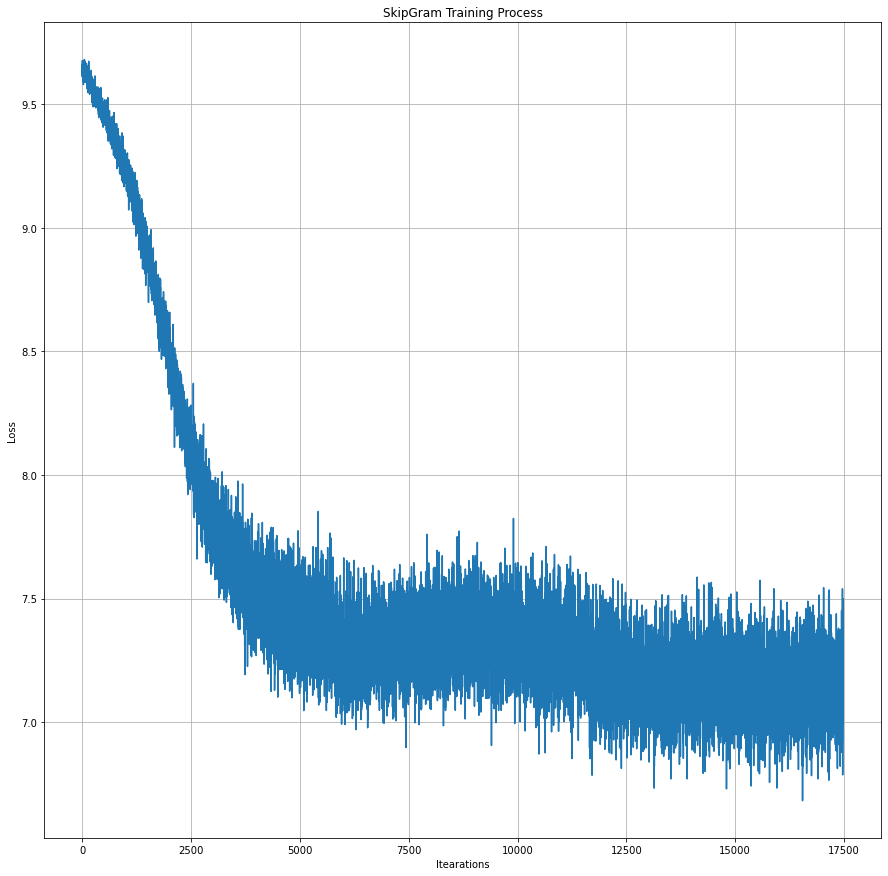

In [62]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses0)

In [63]:
# проверка, что хоть что-то выучилось
assert np.mean(losses0[-1000:]) < 7.5

In [64]:
# буду использовать для сравнения при улучшении
initial_loss = np.mean(losses0)
initial_loss

7.549025700775752

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [65]:
def cos_sim(embedding_matrix, token2id, word1, word2):

    i1 = token2id[word1]
    i2 = token2id[word2]

    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]

    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))

    similarity = torch.dot(v1_n, v2_n).item()

    return similarity

In [66]:
cos_sim(matrix0, word2index, 'день', 'месяц')

0.7800936698913574

In [67]:
cos_sim(matrix0, word2index, 'минута', 'месяц')

0.6742182374000549

In [68]:
cos_sim(matrix0, word2index, 'сотрудник', 'сотрудница')

0.8428484201431274

In [69]:
cos_sim(matrix0, word2index, 'вклад', 'перевод')

0.46486541628837585

In [70]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(matrix0, word2index, 'день', random_word)
'''Косинусная близость слова "день" к случайному выбраному слову \
"{}" равна {:.3f}'''.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "пересчитать" равна 0.708'

In [72]:
all_tokens = []
for text in corpus:
    all_tokens.extend(text)

sorted_freq = Counter(all_tokens).most_common()
sorted_freq[0:5]

[('##число', 35310),
 ('банк', 28716),
 ('карта', 13516),
 ('UNK', 12637),
 ('кредит', 7465)]

In [73]:
top_sorted_freq = sorted_freq[0:200]

In [74]:
tsne = TSNE(n_components=2, init='pca', random_state=117, verbose=2)
reduced = tsne.fit_transform(matrix0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.000s...
[t-SNE] Computed neighbors for 13076 samples in 4.303s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [75]:
top_words = [a for a, _ in top_sorted_freq]

In [76]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

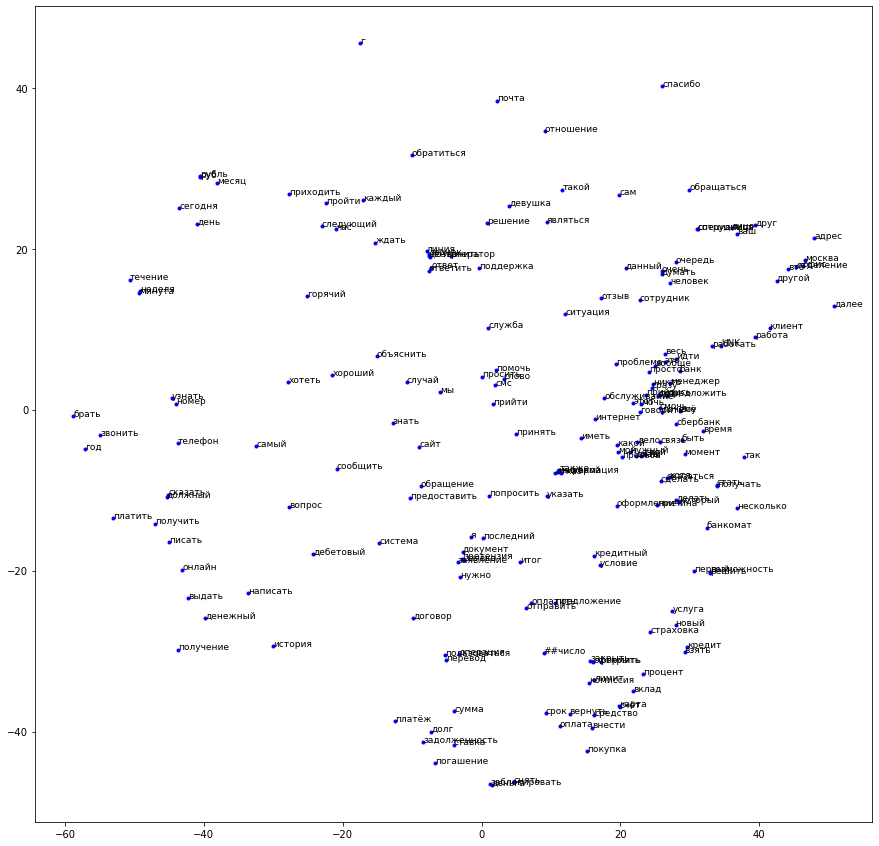

In [77]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов -- взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если вкратце -- он похож на гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем, что у вас и что в оригинале.
3. 9 баллов -- поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как-то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов -- удивили своим подходом (или просто удивили), пока делали на 9 баллов.

In [78]:
import pandas as pd

In [79]:
eval_df = pd.read_csv('data/ru_simlex965_tagged.tsv', sep='\t')
eval_df.rename(columns={'# Word1': 'Word1'}, inplace=True)
eval_df.head()

,Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23


In [80]:
eval_df1 = eval_df.copy()
eval_df1['Word1'] = eval_df1.apply(lambda row:
                                   row['Word1'].split('_')[0], axis=1)
eval_df1['Word2'] = eval_df1.apply(lambda row:
                                   row['Word2'].split('_')[0], axis=1)
eval_df1.head()

,Word1,Word2,Average Score
0,авария,бедствие,6.15
1,август,месяц,2.85
2,авиация,полет,6.77
3,автомобиль,гудок,1.85
4,автомобиль,автострада,1.23


In [81]:
def get_scores(word1_list, word2_list, gold_list,
               embedding_matrix, word2index):

    model_words = list(word2index.keys())
    gold_scores, pred_scores = [], []

    for i, word1 in enumerate(word1_list):
        word2 = word2_list[i]

        # считаем только на словах, которые есть в модели
        if word1 in model_words and word2 in model_words:
            pred_sc = cos_sim(embedding_matrix, word2index,
                              word1, word2)
            gold_scores.append(gold_list[i])
            pred_scores.append(pred_sc)

    return gold_scores, pred_scores

In [82]:
gold, pred = get_scores(eval_df1['Word1'].tolist(),
                        eval_df1['Word2'].tolist(),
                        eval_df1['Average Score'].tolist(),
                        matrix0, word2index)

In [83]:
len(pred)

498

Пояснение про нормализацию: изначально было оговорено, что мы приводим скоры из оценочного датасета в интервал от 0 до 1. Однако косинусная близость возвращает значения от -1 до 1, причем значения, лежащие в pred, не распределены от -1 до 1, они все меньше 1 по модулю. Можно нормировать оценочные скоры от -1 до 1, но это все равно не будет честно, потому что у нас нет оценок для слов, которым косинусная близость приписала бы, например, значение 1. Сранивать значения, заведомо лежащие в разных интервалах, звучит как провальная затея. Поэтому я буду одинаково нормировать все скоры (и голд, и предиктед), приводя их в интервал от -1 до 1.

In [84]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [85]:
def normalize_scores(scores):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    norm_scores = scaler.fit_transform(
        np.array(scores).reshape(-1, 1))
    return norm_scores

In [86]:
def count_mse(gold, pred):

    gold = np.array(normalize_scores(gold))
    pred = np.array(normalize_scores(pred))

    mse = mean_squared_error(gold, pred)

    return mse

In [87]:
initial_mse = count_mse(gold, pred)
initial_mse

0.7064294291886518

# Улучшения
### Эксперимент 1: эпохи
Не меняя корпус и препроцессинг, попробуем увеличить количество эпох. Остальные параметры пока по умолчанию.

In [88]:
losses1, matrix1 = train_model(word2index, epochs=5)

Epoch 5: 100%|█████████████████████████████████████████████████| 2983124/2983124 [00:44<00:00, 66536.60it/s, loss=7.05]


In [89]:
def get_pred_and_mse(eval_df, embedding_matrix, word2index):

    gold, pred = get_scores(eval_df['Word1'].tolist(),
                            eval_df['Word2'].tolist(),
                            eval_df['Average Score'].tolist(),
                            embedding_matrix, word2index)

    mse = count_mse(gold, pred)

    return mse

In [90]:
mse1 = get_pred_and_mse(eval_df1, matrix1, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(
    initial_loss, np.mean(losses1)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse1))

Mean loss: before -- 7.549, after -- 7.334
MSE: before -- 0.706, after -- 0.644


Ура! Увеличение числа эпох ожидаемо дало прирост качества. На переобучение не похоже -- падает и средний лосс, и MSE.

### Эксперимент 2: размер эмбеддингов
Я буду менять параметры по одному, сравнивая результаты с теми, что получились у самой первой модели с дефолтными параметрами. (То есть сейчас число эпох опять 3, а не 5, и это намеренно).

In [91]:
losses2, matrix2 = train_model(word2index, emb_size=100)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [00:44<00:00, 67367.50it/s, loss=7.11]


In [92]:
mse2 = get_pred_and_mse(eval_df1, matrix2, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses2)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse2))

Mean loss: before -- 7.549, after -- 7.533
MSE: before -- 0.706, after -- 0.625


Чуть-чуть лучше! Можно увеличить до 150.

In [93]:
losses3, matrix3 = train_model(word2index, emb_size=150)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [00:43<00:00, 67889.01it/s, loss=7.12]


In [94]:
mse3 = get_pred_and_mse(eval_df1, matrix3, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses3)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse3))

Mean loss: before -- 7.549, after -- 7.527
MSE: before -- 0.706, after -- 0.621


Попробуем теперь уменьшить (слишком большие эмбеддинги -- тоже плохо, корпус не очень большой).

In [95]:
losses4, matrix4 = train_model(word2index, emb_size=50)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [00:53<00:00, 55964.49it/s, loss=7.11]


In [96]:
mse4 = get_pred_and_mse(eval_df1, matrix4, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses4)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse4))

Mean loss: before -- 7.549, after -- 7.538
MSE: before -- 0.706, after -- 0.821


Вот это было зря, оставляем 150.

### Эксперимент 3: learning rate

In [97]:
losses5, matrix5 = train_model(word2index, lr=0.001)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [01:07<00:00, 44029.07it/s, loss=10.7]


In [98]:
mse5 = get_pred_and_mse(eval_df1, matrix5, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses5)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse5))

Mean loss: before -- 7.549, after -- 9.224
MSE: before -- 0.706, after -- 0.679


MSE падает, но средний Loss растет... Ага, лернинг рейту больше не наливаем (но можно попробовать налить меньше):

In [99]:
losses6, matrix6 = train_model(word2index, lr=0.0005)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [01:05<00:00, 45472.52it/s, loss=7.92]


In [100]:
mse6 = get_pred_and_mse(eval_df1, matrix6, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses6)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse6))

Mean loss: before -- 7.549, after -- 7.743
MSE: before -- 0.706, after -- 0.714


Нет, все равно плохо, попробуем взять даже меньше дефолтного:

In [101]:
losses7, matrix7 = train_model(word2index, lr=0.00005)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [01:07<00:00, 44306.29it/s, loss=7.38]


In [102]:
mse7 = get_pred_and_mse(eval_df1, matrix7, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses7)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse7))

Mean loss: before -- 7.549, after -- 7.835
MSE: before -- 0.706, after -- 0.671


Сдаюсь, оставляем дефолтный))

### Эксперимент 4: другой препроцессинг
Структура оценочного датасета наталкивает на мысль, что можно использовать не только сами слова, но и их частеречные теги. Это довольно распространенный подход, позволяющий решать, среди прочих, проблему "склеивания" эмбеддингов омонимичных лексем. Но для более правильного определения частей речи нужен контекст, а это значит, что для препроцессинга лучше использовать Майстем (он вроде как способен его учитывать). У меня Винда, а на Винде библиотека Майстема адски медленная, так что будем извращаться с консольным. Необходимость использовать контекст не позволяет лемматизировать только уникальные слова, что существенно увеличивает время предобработки.

Новый вариант препроцессинга можно посмотреть в тетрадке new_preprocessing.ipynb, а новый корпус -- в подпапке data (файл new_corpus.json). Если вкратце, то препроцессинг организован так:

1. Корпус делится на 15 примерно равных батчей (иначе итоговые файлы слишком велики и не влазят в память -- целый корпус с грамматической информацией весит больше 2 Гб).
2. Каждая часть парсится консольным Майстемом.
3. Файл с разметкой считывается построчно, собирается информация о леммах и частях речи, при этом не учитывается мусор (который Майстем не распознает): сюда попадают слова в транслите, ссылки, опечатки и т.д. (они бы и так отсеялись при обрезании по порогу).
4. Порог вхождения в корпус -- 10 (т.к. мусора стало меньше, а омонимичные леммы разных частей речи могли раздвоиться или даже растроиться). Итоговый словарь полного корпуса -- 15248 слов, заменено на UNK 51360 слов (1.05%).
5. В остальном все так же: редкие слова заменяются на UNK, идущие подряд UNK'и "схлопываются".

In [103]:
with open('data/new_corpus.json', 'r', encoding='utf-8') as f:
    new_corpus = json.load(f)

In [104]:
len(new_corpus)

100000

In [105]:
# слов "это" и "весь" нет в списке стоп-слов nltk
for text in new_corpus[:5]:
    print(' '.join(text))

главное_ADV это_PRON стабильность_NOUN надежность_NOUN граница_NOUN
очень_ADV удивлять_VERB банк_NOUN траст_NOUN информационный_ADJ обеспечение_NOUN низкий_ADJ уровень_NOUN
весь_PRON прошлый_ADJ отчет_NOUN весь_PRON зеленый_ADJ свежий_ADJ задержка_NOUN число_NOUN день_NOUN
хотеть_VERB обращаться_VERB газпромбанк_NOUN работать_VERB человек_NOUN который_PRON наплевать_VERB клиент_NOUN
вряд_ADV находиться_VERB герой_NOUN осиливать_VERB чтение_NOUN UNK


In [106]:
new_word2index = {}

for text in new_corpus:
    for token in text:
        if token not in new_word2index:
            new_word2index[token] = len(new_word2index)

In [107]:
len(new_word2index)

13613

In [108]:
losses8, matrix8 = train_model(new_word2index)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [01:14<00:00, 40196.76it/s, loss=7.14]


In [109]:
mse8 = get_pred_and_mse(eval_df, matrix8, new_word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses8)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse8))

Mean loss: before -- 7.549, after -- 7.540
MSE: before -- 0.706, after -- 0.812


За потраченные три часа на борьбу с майстемом и огромными файлами, конечно, обидно)) Видимо, Майстем не так уж хорош в учитывании контекста, либо в выброшенный при лемматизации мусор попали какие-то важные данные.

Раз уж новый препроцессинг не улучшил качество, попробуем хотя бы увеличить размер корпуса (правда, он тоже предобработан новым способом).

In [113]:
with open('data/full_new_corpus.json', 'r', encoding='utf-8') as f:
    full_new_corpus = json.load(f)

In [114]:
len(full_new_corpus)

200000

In [115]:
full_word2index = {}

for text in full_new_corpus:
    for token in text:
        if token not in full_word2index:
            full_word2index[token] = len(full_word2index)

In [116]:
len(full_word2index)

14827

In [117]:
losses9, matrix9 = train_model(full_word2index)

Epoch 3: 100%|█████████████████████████████████████████████████| 2983124/2983124 [01:11<00:00, 41661.19it/s, loss=7.11]


In [118]:
mse9 = get_pred_and_mse(eval_df, matrix9, full_word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(initial_loss,
                                                            np.mean(losses9)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, mse9))

Mean loss: before -- 7.549, after -- 7.539
MSE: before -- 0.706, after -- 0.717


Либо с данными все совсем плохо, либо нужно менять размер эмбеддинга и другие параметры, но на это уже нет ни времени, ни энтузиазма.

### Эксперимент 5: объединение параметров
Возьмем подобранные ранее параметры и обучим еще одну модель -- сначала на исходных данных.

In [110]:
new_losses, new_matrix = train_model(word2index, epochs=5,
                                     emb_size=150, lr=0.0001)

Epoch 5: 100%|█████████████████████████████████████████████████| 2983124/2983124 [01:05<00:00, 45275.42it/s, loss=7.03]


In [112]:
new_mse = get_pred_and_mse(eval_df1, new_matrix, word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(
    initial_loss, np.mean(new_losses)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(initial_mse, new_mse))

Mean loss: before -- 7.549, after -- 7.320
MSE: before -- 0.706, after -- 0.627


Вот это уже приятнее! Уменьшились и лосс, и MSE; мы не перескакиваем минимум и не переобучаемся. Рискнем здоровьем и обучим последнюю модель с такими же параметрами, но на бОльшем корпусе.

In [119]:
final_losses, final_matrix = train_model(full_word2index,
                                         epochs=5,
                                         emb_size=150,
                                         lr=0.0001)

Epoch 5: 100%|█████████████████████████████████████████████████| 2983124/2983124 [01:11<00:00, 41448.28it/s, loss=7.04]


In [120]:
final_mse = get_pred_and_mse(eval_df, final_matrix, full_word2index)

print('Mean loss: before -- {:.3f}, after -- {:.3f}'.format(
    initial_loss, np.mean(final_losses)))
print('MSE: before -- {:.3f}, after -- {:.3f}'.format(
    initial_mse, final_mse))

Mean loss: before -- 7.549, after -- 7.342
MSE: before -- 0.706, after -- 0.904


Ладно, это было лишнее))

**Итак, наибольшие улучшения дает:**
1. Увеличение числа эпох до 5 (Mean loss: before -- 7.549, after -- 7.334; MSE: before -- 0.706, after -- 0.644).
2. Увеличение размера эмбеддинга до 150 (Mean loss: before -- 7.549, after -- 7.527; MSE: before -- 0.706, after -- 0.621) -- я пробовала и дальнейшее увеличение, но там качество начинает падать.
3. Одновременное увеличение числа эпох и размера эмбеддингов показывает следующие результаты: **Mean loss: before -- 7.549, after -- 7.320; MSE: before -- 0.706, after -- 0.627** (оптимально, если брать в расчет и лосс, и MSE).

Результатам вроде как можно верить, потому что элемент случайности сведен к минимуму (см. начало тетрадки, где задаются сиды). MSE довольно высокая, но это связано с тем, как я нормализовала скоры (когда нормализация была от 0 до 1, MSE была что-то около 0.13).

### Потенциальные улучшения
Я все еще считаю, что использование контекста и POS-тегов -- хорошая идея, но нужно более тщательно разбираться с тем, что майстем не смог лемматизировать (может быть, помимо мусора туда попали какие-то названия и имена собственные). Еще интересно поменять корпус, потому что оценочный датасет включает множество самых разнообразных понятий, а наш корпус, судя по всему, представляет собой отзывы о банках (?? я не очень вчитывалась, не бейте), поэтому даже те слова оценочного датасета, которые попали в готовую модель, могли получить не очень хорошую репрезентацию.

### Финальный комментарий
Оценивая мое решение, пожалуйста, примите во внимание те удивительные вещи, которые мне пришлось совершить :) Мой ноут в субботу вечером оказался залит чаем и сейчас в ремонте, так что пришлось сдувать пыль с папиного рабочего ноутбука и с нуля устанавливать на нем питон и анаконду, настраивать GPU (что я делала в первый раз) и за воскресенье заново писать весь код домашки.